## 初期設定的なもの

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

In [ ]:
def calc_square_error(O, T):
    return np.sum(np.square(O - T))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y*(1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - np.square(np.tanh(y))

def relu(x):
    #return x if x > 0 else 0
    return x * (x > 0)

def drelu(y):
    #return 1 if y > 0 else 0
    return 1 * (y > 0)

class Layer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size                           # 入力数
        self.output_size = output_size                         # ニューロン数と同じ
        self.neurons_W = (np.random.rand(output_size, input_size) - 0.5) * 0.1 # ニューロンごとに入力と同数の足がある分の重み
        self.neurons_b = (np.random.rand(output_size) - 0.5) * 0.2             # ニューロンごとのしきい値
        self.neurons_d = np.zeros(output_size)                                 # ニューロンごとの誤差修正値
    
    def h(self, x):
        #return sigmoid(x)
        return tanh(x)
        #return relu(x)
    
    def dh(self, y):
        #return dsigmoid(y)
        return dtanh(y)
        #return drelu(y)

    def output_layer(self, X):
        y = np.zeros(self.output_size)
        for i in range(self.output_size):
            # y = h(sum(W*X) - b)
            y[i] = self.h(np.sum(self.neurons_W[i]*X) - self.neurons_b[i])
        return y

    def train_layer(self, X):
        for i in range(self.output_size):
            # W = W - (-alpha*d*X)
            self.neurons_W[i] -= -alpha*self.neurons_d[i]*X
        return
    
    # 出力層での自分自身の誤差修正値をセット
    def backprop_layer_output(self, O, T):
        # d = (T - O)*dh(O)
        self.neurons_d = (T - O)*self.dh(O)
        return

    # 前のレイヤーへの誤差修正値を算出
    def backprop_layer(self):
        total_prev_D = np.zeros(self.input_size)
        for i in range(self.output_size):
            #total_prev_D += W*d
            total_prev_D += self.neurons_W[i]*self.neurons_d[i]
        return total_prev_D

    # 後のレイヤーで計算された誤差修正値に出力値を掛けて自レイヤーに値をセット
    def set_layer_d(self, D, O):
        # d = D*dh(O)
        self.neurons_d = D*self.dh(O)


In [ ]:
def smaller(image):
    def seri(x, y):
        return y*28 + x

    simages = np.zeros(14*14)
    for i in range(14):
        for j in range(14):
            x, y = j*2, i*2
            avg = (image[seri(x+0, y+0)] + image[seri(x+0, y+1)] + image[seri(x+1, y+0)] + image[seri(x+1, y+1)])/4.0
            simages[i*14 + j] = avg
    return simages

In [ ]:
plt.figure(figsize=(20,10))

In [ ]:
def plotImage(image, w, h, i):
    plt.subplot(w, h, i + 1)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")


## numpyで配列の範囲の扱い

In [ ]:
test1 = np.array([[11, 12, 13, 14], [21, 22, 23, 24], [31, 32, 33, 34]])

In [ ]:
test1[1:3, 0:2]

In [ ]:
test2 = test1[1:3, 0:2]

In [ ]:
test2[:] = test2 * 2

In [ ]:
test1

In [ ]:
np.pad(test1, [(2, 2), (2, 2)], 'constant')

In [ ]:
test1.shape

In [ ]:
test1.reshape(3, 4, 1)

In [ ]:
test1.reshape(-1)

In [ ]:
test1.reshape(-1).reshape(2, 3, 2)

In [ ]:
test1

In [ ]:
test1.max()

In [ ]:
test1.max(axis=1)

In [ ]:
test3 = test1.reshape(-1).reshape(2, 3, 2)

In [ ]:
test3

In [ ]:
test3.max(axis=2)

In [ ]:
test4 = np.array([[["R11", "G11", "B11"], ["R12", "G12", "B12"], ["R13", "G13", "B13"], ["R14", "G14", "B14"]],
                  [["R21", "G21", "B11"], ["R22", "G22", "B12"], ["R23", "G23", "B23"], ["R24", "G23", "B24"]]])

In [ ]:
test4

In [ ]:
test4.shape

In [ ]:
(h, w, d) = test4.shape

In [ ]:
test4.transpose((2, 0, 1))

In [ ]:
test4.transpose((2, 0, 1)).shape

## convolutionとpoolingの順方向実装

In [ ]:
def conv(layer, X):
    (height, width, depth) = X.shape # 入力は3次元配列を想定
    conv_out = np.zeros((height, width, 20))  # 縦14 x 横14 x 種20 の出力結果用
    conv_size = 3 # convolution 3x3 の入力の畳み込み層を使う
    conv_min = -1
    conv_max = 1
    pad = 2
    Xpad = np.pad(X, [(pad, pad), (pad, pad), (0, 0)], 'constant') # 上下左右2つづつpaddingする
    for y in range(height):
        for x in range(width):
            window = Xpad[y+conv_min+pad : y+conv_max+pad+1,
                          x+conv_min+pad : x+conv_max+pad+1] # 3x3の窓を切り出す
            conv_out[y, x] = layer.output_layer(window.reshape(-1)) # 窓は2次元配列なので1次元化してニューロンに渡す
            #print("y:" + str(y) + " x:" + str(x) + " data:" + str(window))
            #plotInput(inp[y:y+ch, x:x+cw], w, h, x, y)
    return conv_out

In [ ]:
layer1 = Layer(3*3, 20) # 3x3の入力で20種類まで判定出来るたたみこみ層
layer1.neurons_W = (np.random.rand(layer1.output_size, layer1.input_size) - 0.5) * 1.0 # わかりやすくするため重み初期値を大きくする

alpha = 0.1
fig = plt.figure(figsize=(8, 6))

def test_convolution(train_count):
    images, labels = mnist.train.next_batch(train_count)
    square_error = 0.0
    for i in range(len(images)):
        X = smaller(images[i]).reshape(14, 14, 1) # 3次元配列で入力
        C = conv(layer1, X)

        #print("conv:\n" + str(C))
        plt.subplot(3, 5, 1)
        plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
        plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
        plt.imshow(X.reshape(14, 14), vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")
        images = C.transpose((2, 0, 1)) # 出力を特徴抽出ニューロン毎に取り出せるように配列順番を入れ替える
        for j in range(5):
            image = images[j]
            plt.subplot(3, 5, j + 5 + 1)
            plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
            plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
            plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")

In [ ]:
test_convolution(1)

In [ ]:
def pooling(conv_out):
    (conv_out_h, conv_out_w, conv_out_z) = conv_out.shape
    # pooling 2x2 の範囲で最大のものを抽出
    (pw, ph) = 2, 2
    pooling_out = np.zeros((conv_out_h // ph, conv_out_w // pw, conv_out_z))  # 縦6 x 横6 x 種20 の出力結果用
    for z in range(conv_out_z):
        for y in range(0, conv_out_h, ph):
            for x in range(0, conv_out_w, pw):
                window = conv_out[y:y+ph, x:x+pw, z]
                value = window.max()
                index = window.argmax()
                pooling_out[y // ph, x // pw, z] = value # そのpoolingで最大のものを詰める
                #print("y:" + str(max_y) + " x:" + str(max_x) + " z:" + str(z) + " value:" + str(value))
    return pooling_out

In [ ]:
def test_pooling(train_count):
    images, labels = mnist.train.next_batch(train_count)
    square_error = 0.0
    for i in range(len(images)):
        X = smaller(images[i]).reshape(14, 14, 1)
        C = conv(layer1, X)
        P = pooling(C)

        #print("conv:\n" + str(C))
        #print("pooling:\n" + str(P))
        plt.subplot(3, 5, 1)
        plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
        plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
        plt.imshow(X.reshape(14, 14), vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")
        images = C.transpose((2, 0, 1))
        for j in range(5):
            image = images[j]
            plt.subplot(3, 5, j + 5 + 1)
            plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
            plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
            plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")
        images = P.transpose((2, 0, 1))
        for j in range(5):
            image = images[j]
            plt.subplot(3, 5, j + 10 + 1)
            plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
            plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
            plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")


In [ ]:
test_pooling(1)

## 学習の実装

In [162]:
class Clayer:
    def __init__(self, width, height, depth, output_depth):
        (self.width, self.height, self.depth) = width, height, depth
        self.output_depth = output_depth
        self.conv_size = 3 # convolution 3x3 の入力の畳み込み層を使う
        self.conv_min = -1
        self.conv_max = 1
        self.pad = 2
        self.conv_layer = Layer(self.conv_size**2*self.depth, self.output_depth) # 3x3xdepthの入力で20種類まで判定出来るたたみこみ層
        self.Xyx = np.zeros((self.height, self.width, self.conv_size**2*self.depth)) # x,y毎のconv_layerへの入力値を保持
        self.Oyx = np.zeros((self.height, self.width, self.output_depth)) # x,y毎のconv_layerからの出力値を保持
        self.backprop_Dyx = np.zeros((self.height, self.width, self.output_depth)) # 後ろのレイヤーから渡ってきた誤差を入れる
        self.Dyx = np.zeros((self.height, self.width, self.depth)) # 前のレイヤーに渡す誤差を積算する入れ物

    def output_layer(self, X):
        Xpad = np.pad(X, [(self.pad, self.pad), (self.pad, self.pad), (0, 0)], 'constant') # 上下左右2つづつpaddingする
        for y in range(self.height):
            for x in range(self.width):
                window = Xpad[y+self.conv_min+self.pad : y+self.conv_max+self.pad+1,
                              x+self.conv_min+self.pad : x+self.conv_max+self.pad+1] # 3x3の窓を切り出す
                self.Xyx[y, x] = window.reshape(-1) # 窓は3次元配列なので1次元化してニューロンに渡す
                self.Oyx[y, x] = self.conv_layer.output_layer(self.Xyx[y, x])
        return self.Oyx

    # 後のレイヤーで計算された誤差修正値をセット
    def set_layer_d(self, D):
        self.backprop_Dyx = D # 後ろのレイヤーから渡ってきた誤差

    # 前のレイヤーへの誤差修正値を算出
    def backprop_layer(self):
        Dyx_pad = np.zeros((self.height+self.pad*2, self.width+self.pad*2, self.depth)) # 上下左右2つづつpaddingしたサイズ
        for y in range(self.height):
            for x in range(self.width):
                # x, yの場所にわたってきた誤差と出力から入力毎の誤差を計算して埋める
                self.conv_layer.set_layer_d(self.backprop_Dyx[y, x], self.Oyx[y, x])
                D = self.conv_layer.backprop_layer()
                window = Dyx_pad[y+self.conv_min+self.pad : y+self.conv_max+self.pad+1,
                                 x+self.conv_min+self.pad : x+self.conv_max+self.pad+1] # 誤差を埋め込むための3x3の窓を切り出す
                window[:] += D.reshape(self.conv_size, self.conv_size, self.depth) # 入力毎の誤差として積算する
        self.Dyx = Dyx_pad[self.pad:self.height+self.pad, self.pad:self.width+self.pad] # padding削除した範囲を取得
        return self.Dyx

    def train_layer(self):
        for y in range(self.height):
            for x in range(self.width):
                self.conv_layer.set_layer_d(self.backprop_Dyx[y, x], self.Oyx[y, x])
                self.conv_layer.train_layer(self.Xyx[y, x])
        return

In [141]:
layer1 = Clayer(14, 14, 1, 20)
layer2 = Layer(14*14*20, 10)

alpha = 0.02

def train_convolution(train_count):
    images, labels = mnist.train.next_batch(train_count)
    square_error = 0.0
    for i in range(len(images)):
        T = labels[i]
        X = smaller(images[i]).reshape(14, 14, 1) # 3次元配列で入力
        C = layer1.output_layer(X)
        Y = layer2.output_layer(C.reshape(-1))
        layer2.backprop_layer_output(Y, T)
        D1 = layer2.backprop_layer().reshape(14, 14, 20)
        layer1.set_layer_d(D1)
        #D0 = layer1.backprop_layer()
        layer2.train_layer(C.reshape(-1))
        layer1.train_layer()
        square_error += calc_square_error(Y, T)
    print(square_error/train_count/20) # 1ニューロンあたりの誤差

In [ ]:
fig = plt.figure(figsize=(8, 6))

def test_convolution():
    images, labels = mnist.train.next_batch(1)
    square_error = 0.0
    T = labels[0]
    X = smaller(images[0]).reshape(14, 14, 1) # 3次元配列で入力
    C = layer1.output_layer(X)
    Y = layer2.output_layer(C.reshape(-1))

    print("T:" + str(T) + " Y:" + str(Y))
    plotImage(X.reshape(14, 14), 5, 5, 0)
    images = C.transpose((2, 0, 1)) # 出力を特徴抽出ニューロン毎に取り出せるように配列順番を入れ替える
    for j in range(20):
        plotImage(images[j]+0.5, 5, 5, j + 5)

def disp_convolution_W():
    for i in range(20):
        plotImage(layer1.conv_layer.neurons_W[i].reshape(3, 3)+0.5, 4, 5, i)
   

In [171]:
train_convolution(100)

0.0306939624968


In [167]:
alpha = 0.005

In [ ]:
disp_convolution_W()

In [163]:
layer1 = Clayer(14, 14, 1, 20)
layer2 = Clayer(14, 14, 20, 20)
layer3 = Layer(14*14*20, 10)

alpha = 0.02

def train_convolution(train_count):
    images, labels = mnist.train.next_batch(train_count)
    square_error = 0.0
    for i in range(len(images)):
        T = labels[i]
        X = smaller(images[i]).reshape(14, 14, 1) # 3次元配列で入力
        C1 = layer1.output_layer(X)
        C2 = layer2.output_layer(C1)
        Y = layer3.output_layer(C2.reshape(-1))
        layer3.backprop_layer_output(Y, T)
        D2 = layer3.backprop_layer().reshape(14, 14, 20)
        layer2.set_layer_d(D2)
        D1 = layer2.backprop_layer()
        layer1.set_layer_d(D1)
        layer3.train_layer(C2.reshape(-1))
        layer2.train_layer()
        layer1.train_layer()
        square_error += calc_square_error(Y, T)
    print(square_error/train_count/20) # 1ニューロンあたりの誤差

In [173]:
train_convolution(100)

0.0283345980365


In [ ]:
alpha = 0.005

In [176]:
fig = plt.figure(figsize=(8, 6))

def test_convolution():
    images, labels = mnist.train.next_batch(1)
    square_error = 0.0
    T = labels[0]
    X = smaller(images[0]).reshape(14, 14, 1) # 3次元配列で入力
    C1 = layer1.output_layer(X)
    C2 = layer2.output_layer(C1)
    Y = layer3.output_layer(C2.reshape(-1))

    print("T:" + str(T) + " Y:" + str(Y))
    plotImage(X.reshape(14, 14), 9, 5, 0)
    images = C1.transpose((2, 0, 1)) # 出力を特徴抽出ニューロン毎に取り出せるように配列順番を入れ替える
    for i in range(20):
        plotImage(images[i]+0.5, 9, 5, i + 5)
    images = C2.transpose((2, 0, 1)) # 出力を特徴抽出ニューロン毎に取り出せるように配列順番を入れ替える
    for i in range(20):
        plotImage(images[i]+0.5, 9, 5, i + 5 + 20)

def disp_convolution_W():
    for i in range(20):
        plotImage(layer1.conv_layer.neurons_W[i].reshape(3, 3)+0.5, 4, 5, i)
  

T:[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.] Y:[-0.1193301   0.17383922  0.52143895  0.04758421  0.20995478 -0.13245328
  0.06140433 -0.09015031  0.15566644  0.00264202]


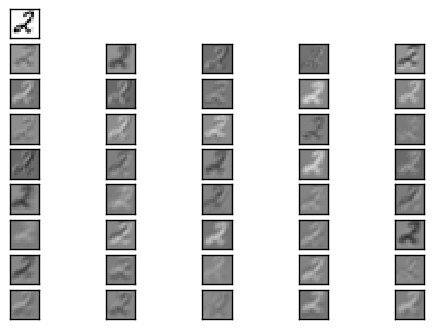

In [179]:
test_convolution()

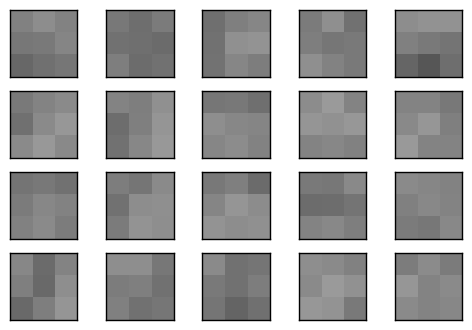

In [180]:
disp_convolution_W()